In [12]:
from simulation_functions import index, simulation_, plot
from interpolation_functions import T_K
from make_noise_updated import simulate_noise
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sim = simulate_noise(15) # first argument dt_max: time delay is chosen randomly between 0 and dtmax.
time_delays = sim[2]
ts = sim[0]+np.max(time_delays) # observation time sample (same for all curves= non_shifted)
ts_shifted = sim[4]# 4xs made of shifted ts by the time delay of each curve : ts_shifted[i]= ts+time_delay[i]
fs = sim[1]
f_truth = sim[5]
f = sim[6]
t = sim[7]

sampling = 3
h=sampling
# desired sampling for each curve


tk = np.linspace(np.min(ts),np.max(ts),np.int(np.abs((np.min(ts)-np.max(ts))/h)),dtype=float,retstep=True)[0]  # [1] gives approx : h


# dt is part of the argument ts+dt -tk of the sinc matrix
dt = np.array([1.,1.,1.,1.])
arg = np.argsort(time_delays)[::-1] # in index terms: from highest time delay to lowest
dt[arg[0]] = 0 #curve with highest time delay has dt = 0
#in what comes: curve with ith highest time delay has :dt = max time delay- ith highest time delay
dt[arg[1]] = np.max(time_delays)-time_delays[arg[1]]
dt[arg[2]] = np.max(time_delays)-time_delays[arg[2]]
dt[arg[3]] = np.max(time_delays)-time_delays[arg[3]]

#print('k = ', len(tk),'\ns = ', len(ts))
matrix = []
for i in range(4):
    matrix.append(np.array([(ts[:,np.newaxis])-dt[i]-tk[np.newaxis,:]])) # change time_delays to dt #
matrix = np.array(matrix)

A = np.sinc(np.concatenate([matrix[0],matrix[1],matrix[2],matrix[3]],axis =0)/h) # 4 x s x K  , add h* to try

Y= np.concatenate([fs[0][np.newaxis,:],fs[1][np.newaxis,:],fs[2][np.newaxis,:],fs[3][np.newaxis,:]]) # 4 x s
#print('A.shape: ', A.shape, '\nY.shape: ', Y.shape)

In [13]:
# plt.plot(sim[0], fs[0],'o')
# plt.plot(sim[0], fs[1]+0.1,'o')
# plt.plot(sim[0], fs[2]+0.3,'o')
# plt.plot(sim[0], fs[3]+0.5,'o')
# plt.show()

In [14]:
# multiplication functions:
noise_std = sim[3]
def AT(X,A,Y): 
    '''
    calculateS the weighted mean of A.T(Y-AX)
    input:
    X : array with shape k, solution of interpolation
    A : tensor of shape 4xsxk, sinc matrix
    Y : matrix of shape 4xs, magnitudes of original time sampling
    '''
    sum_ = 0
    for i in range(4):
        sum_ += np.dot(A[i].T, Y[i] - A[i] @ X)#*((1/noise_std[i])**2)
    
    return sum_#/np.sum(1/(noise_std**2))

def multiplication(X,S): # X.S
    '''
    multiplies X by S[i] and takes the arithmetic mean
    '''
    this =[]
    for i in range(4):
        this.append(np.dot(X,S[i]))
    this = np.array(this)
    return np.mean(this,axis=0)

def multiplication_T(X,S): # X.S.T

    '''
    multiplies X by S[i].T and take the arithmetic mean
    '''
    this =[]
    for i in range(4):
        this.append(np.dot(X,S[i].T))
    this = np.array(this)
    return np.mean(this,axis=0)

In [15]:
def linorm(S, nit):
    x0 = np.random.rand(S.shape[1])  # chose [1] per the implementation of the power iteration method in wiki
    x0 = x0 /np.linalg.norm(x0)
    for i in range(nit):
        x = multiplication(x0,S)#np.dot(x0,S)
        xn = np.linalg.norm(x)
        xp = x / xn#     
        y = multiplication_T(xp,S) # the S.T is done within the functionas S[i].T not S.T[i]
        yn = np.linalg.norm(y)  
        x0 = y / yn
    return 1./xn
mu = linorm(A,20)/170 # = 0.0038

X = np.zeros(len(tk))

count = 0
R = [np.sum(Y ** 2)]
epsilon = 0.3




In [16]:
# max_ = []
# for i in range(4):
#     max_.append(np.max((fs[i][1:]-fs[i][:-1])))#/((ts-dt[i])[1:]-(ts-dt[i])[:-1])))

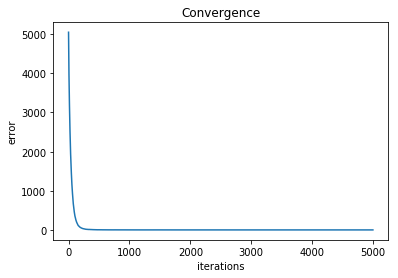

In [17]:
max_var = np.abs(np.max((f[1:]-f[:-1])))#/(t[1:]-t[:-1]))) # exact if without noise (f doesnt have noise)

# with total variation
while (R[-1] > epsilon) and (
        count < 5000):  # 5000 is a good amount of counts
    X_new = X + mu * AT(X,A,Y)
    X = X_new.copy()   
    S_var = (X[:-1]-X[1:])#/((tk[:-1]-tk[1:]))
    sign = np.sign(S_var[np.abs(S_var) >2*max_var])
    loc = np.where(np.abs(S_var) >2*max_var)
    X[loc] = X[loc] - 2*max_var*sign
    
    R.append(np.sum((Y - A @ X) ** 2.))
    count += 1


plt.title('Convergence')
plt.plot(np.array(R[1:]))
plt.xlabel('iterations')
plt.ylabel('error')
plt.show()

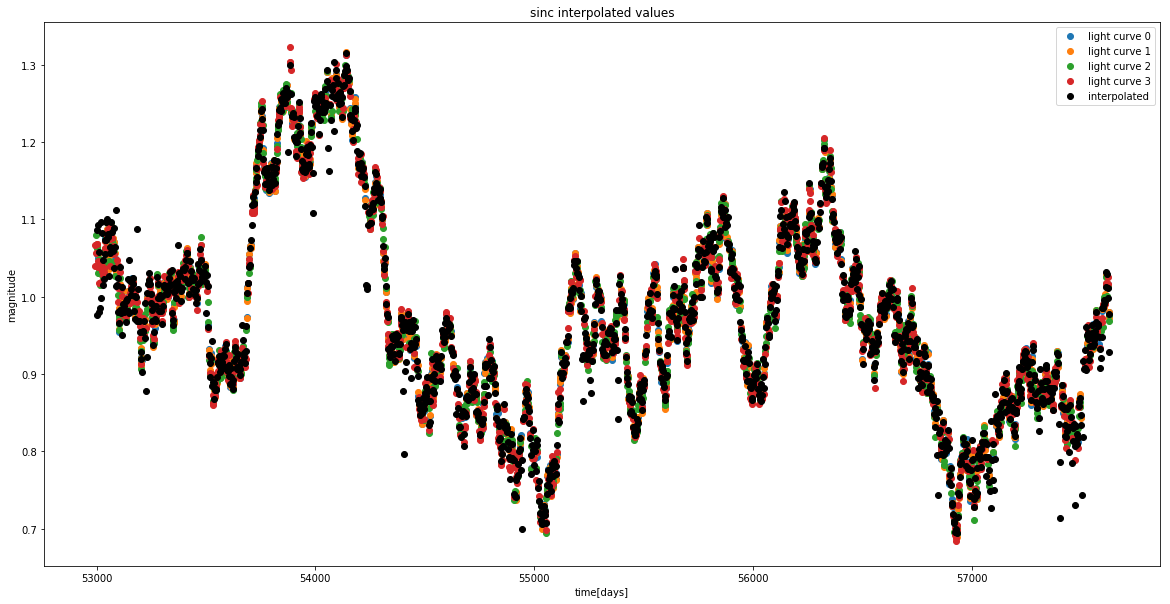

In [18]:
%matplotlib inline
cut = np.logical_and(X < np.max(Y), X > np.min(Y))
plt.figure(figsize=(20,10))

for i in range(4):
    plt.plot(ts-dt[i], Y[i], 'o', label='light curve '+str(i))    

plt.plot(tk[cut], X[cut],'o', label='interpolated', color='black')
#plt.plot(tk, X,'o', label='interpolated', color='black')
#plt.plot(t,f,'o', label = 'true')
plt.xlabel('time[days]')
plt.ylabel('magnitude')
plt.title('sinc interpolated values')
plt.legend()
#plt.savefig("total variation NOT scaled by gap, using 4,4,3.png")
plt.show()
